In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import filters, io, transform, exposure, morphology, segmentation
from pandas import DataFrame as df
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)

# Загрузка изображения

In [2]:
def get_image(pattern, n):
    ''' Reads image from disk '''
    imc = skimage.io.imread_collection(pattern)
    im = imc[1]
    return(im)

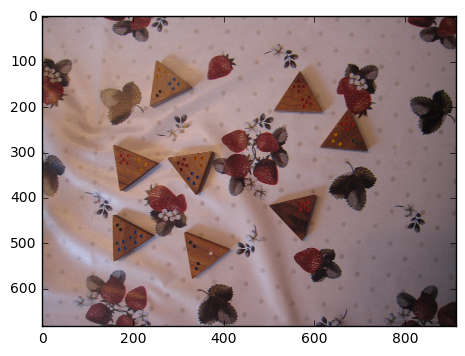

In [3]:
im = get_image("Pict_3*", 0)
plt.imshow(im)

# Обраружение треугольников
Схема:

* Перевод в черно-белый формат
* Обнаружение границ (```Canny edge detection```)
* Filling holes using ```ndi.binary_fill_holes```
* Простановка меток (```ndi.label```)
* Оставляем только большие объекты по площади (> 3000)

In [4]:
def get_im_gray(im):
    return(np.mean(im, axis = 2))

def get_edges(im_gray):
    ''' get edges using canny '''
    im_edges = canny(im_gray / 255.)
    return(im_edges)

def get_filled(im_edges):
    ''' fill holes '''
    im_filled = ndi.binary_fill_holes(im_edges)
    return(im_filled)

def get_labels(inp, mask_update):
    ''' Obtain labels using ndi.label '''
    labels, _ = ndi.label(inp)
    sizes = np.bincount(labels.ravel())
    mask_sizes = mask_update(sizes)
    mask_sizes[0] = 0
    cleaned = mask_sizes[labels]
    labels, idx = ndi.label(cleaned)
    return(labels, idx)

def get_range(labels, label):
    ''' Obtain x-y range for specific label'''
    v = np.where(labels == label)
    return(np.min(v[0]), np.max(v[0]), np.min(v[1]), np.max(v[1]))

def get_length(r):
    return(np.linalg.norm([r[0] - r[1], r[2]- r[3]]))

def get_center(r):
    ''' Get center position of label '''
    return(np.mean([r[0], r[1]]), np.mean([r[2], r[3]]))

def get_triangles(labels, idx, plot):
    ''' Find triangles on the image '''
    triangles = []
    ranges = []
    for label in range(1, idx + 1):
        r = get_range(labels, label)
        ranges.append(r)
        tr = im[r[0]:r[1], r[2]:r[3]]
        triangles.append(tr)
    return triangles, ranges

def segment_triangles(im, plot = False):
    ''' Segment triangles from image '''
    im_gray = get_im_gray(im)
    im_edges = get_edges(im_gray)
    im_filled = get_filled(im_edges)
    labels, idx = get_labels(im_filled, lambda x : x > 3000)
    
    if plot:
        plt.figure(0)
        plt.imshow(im_gray, cmap = 'gray')
        plt.figure(1)
        plt.imshow(im_edges, cmap = 'gray')
        plt.figure(2)
        plt.imshow(im_filled, cmap = 'gray')
        plt.figure(3)
        plt.imshow(labels)
        
    return(get_triangles(labels, idx, plot))

Обнаружение треугольников. Будет обнаружен 1 лишний объект, но потом он будет убран из массива

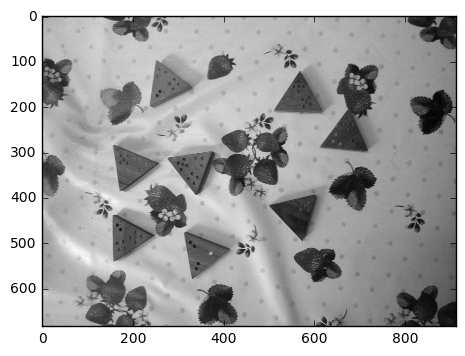

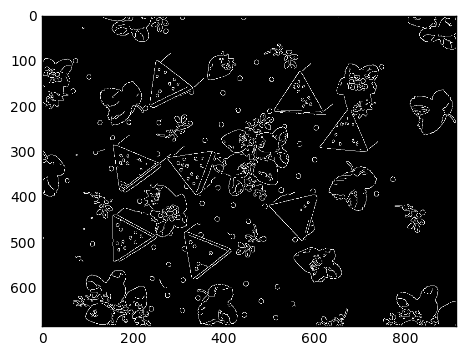

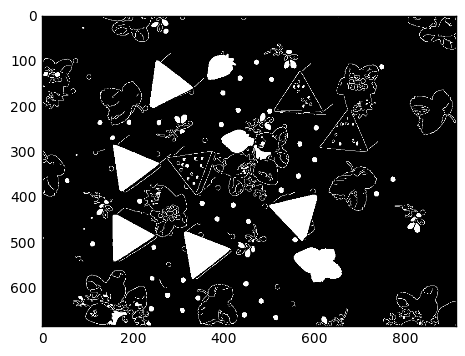

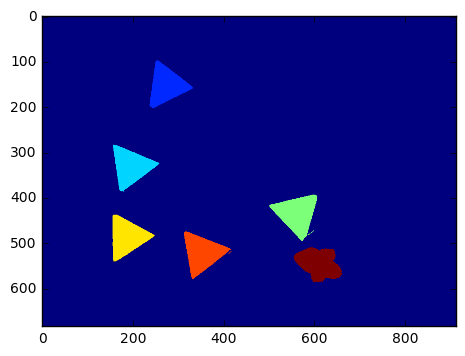

In [5]:
# Detecting triangles
triangles, ranges = segment_triangles(im, True)

(100, 203, 236, 331)
(285, 388, 156, 257)
(395, 496, 499, 604)
(439, 541, 155, 247)
(476, 580, 312, 416)
(511, 587, 553, 658)


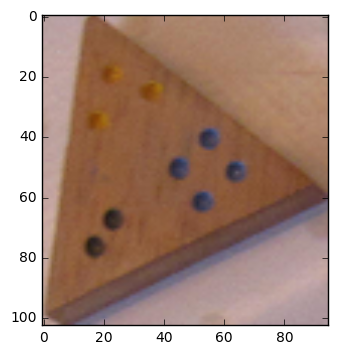

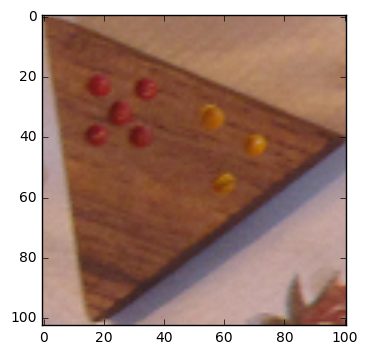

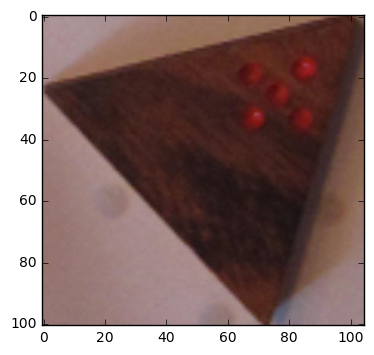

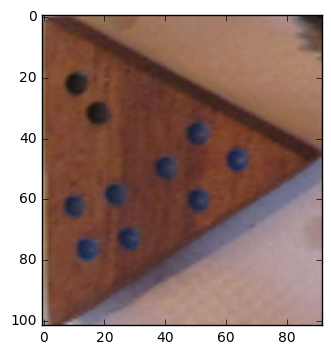

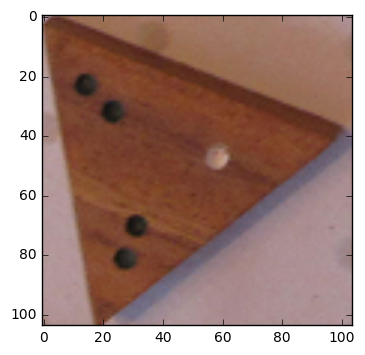

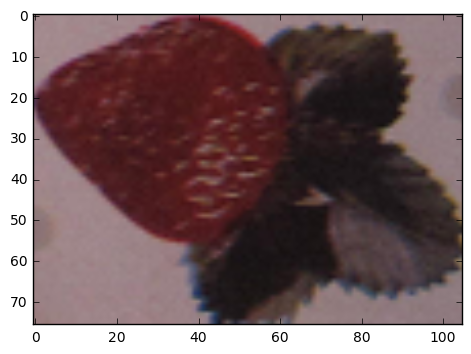

In [6]:
# Showing triangles and their ranges
i = 0
for t, r in zip(triangles, ranges):
    print(r)
    plt.figure(i)
    plt.imshow(t)
    i += 1

# Обработка отдельных треугольников
 
 * Применение фильтра ```sobel``` для обнаружения границ
 * Бинаризация
 * Ищем короткие (по длине < 19) объекты с площадью от 30 до 150 -- маленькие точки
 * Ищем длинные линии (площадь > 150) -- границы треугольника
 * Применяем преобразования Хафа для обнаружения границ треугольника
 * Решается система уравнений для определения углов треугольника
 * Для каждой маленькой точки ищем ближайший угол, считаем, сколько точек в каждом углу

In [7]:
def get_triangle_map(triangle):
    ''' Apply sobel to triangle '''
    triangle = np.mean(triangle, axis = 2)
    tr_map = sobel(triangle) > 7
    #plt.imshow(tr_map, cmap = 'gray')
    return(tr_map)

def get_points(tr_points, max_length):
    ''' Obtain points from triangle '''
    points = []
    for i in range(1, np.max(tr_points) + 1):
        length = get_length(get_range(tr_points, i))
        #print("Length %d %f" % (i, length))
        if length <= max_length:
            c = get_center(get_range(tr_points, i))
            c = [c[1], c[0]]
            points.append(c)
        else:
            tr_points[tr_points == i] = 0
    return(np.array(points))

def get_corners(tr_frame, plot = False):
    ''' Obtain corners from tr_frame using hough transform '''
    h, theta, d = hough_line(tr_frame)
    peaks = hough_line_peaks(h, theta, d)

    i = 0
    arr = zip(*peaks)
    
    if len(arr) > 3:
        return(None)
    
    corners = []
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            _, angle1, dist1 = arr[i]
            _, angle2, dist2 = arr[j]
            a1 = -1. / np.tan(angle1)
            a2 = -1. / np.tan(angle2)
            b1 = dist1 / np.sin(angle1)
            b2 = dist2 / np.sin(angle2)

            x = (b2 - b1) / (a1 - a2)
            y = (a1 * b2 - b1 * a2) / (a1 - a2)

            corners.append([x, y])

            j += 1
        i += 1
        
    corners = np.array(corners)
        
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(tr_frame, cmap='gray')

        for _, angle, dist in zip(*peaks):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - tr_frame.shape[1] * np.cos(angle)) / np.sin(angle)
            ax.plot((0, tr_frame.shape[1]), (y0, y1), '-r')
        d = 30
        ax.set_xlim((-d, tr_frame.shape[1] + d))
        ax.set_ylim((d + tr_frame.shape[0], -d))
        ax.scatter(corners[:, 0], corners[:, 1])
        
    return(corners)

def get_nearest_corner(corners, pt):
    ''' Nearest corner for point '''
    return(np.argmin(np.linalg.norm(corners - np.array(pt), axis=1)))

def get_corners_count(corners, points):
    num_corners = len(corners)
    corners_count = np.zeros(num_corners)
    for p in points:
        cr = get_nearest_corner(corners, p)
        corners_count[cr] += 1
    return(corners_count)

def get_triangle_output(triangle, r, plot = False):
    ''' Process single triangle '''
    if plot:
        plt.figure(0)
        plt.imshow(triangle, cmap='gray')
    # center of triangle
    c = get_center(r)

    # map for triangle
    tr_map = get_triangle_map(triangle)
    
    # small points on triangle
    tr_points = get_labels(tr_map, lambda x : (x > 30) & (x < 150))[0]
    points = get_points(tr_points, 19)
    if plot:
        plt.figure(1)
        plt.imshow(tr_points)
    
    # frame of the triangle
    tr_frame = get_labels(tr_map, lambda x : (x > 150))[0] > 0
    corners = get_corners(tr_frame, plot)
    if type(corners) == type(None):
        return(None)
    
    corners_count = get_corners_count(corners, points)
    
    if plot:
        plt.imshow(triangle)
        plt.scatter(corners[:, 0], corners[:, 1], c = 'green')
        plt.scatter(points[:, 0], points[:, 1])
    
    return(c, corners, points, corners_count)

# Вывод программы
Формат: x, y, m1, m2, m3

In [8]:
for triangle, r in zip(triangles, ranges):
    res = get_triangle_output(triangle, r)
    if type(res) != type(None):
        center, corners, points, corners_count = res
        print("%d %d %d %d %d" % (center[0], center[1], corners_count[0], corners_count[1], corners_count[2]))

151 283 3 2 4
445 551 0 1 4
490 201 1 4 4
528 364 1 2 1


# Итоговая картинка

Зелёные точки -- найденные и распознанные треугольники
Красные точки -- найденные треугольники, которые оказались не треугольниками (>3 прямых в преобразовании Хаффа)

Заметим, что выделенный ранее ошибочно объект теперь убран из ответа (помечен красным), так как количество линий в преобразовании Хаффа для него было не равно 3

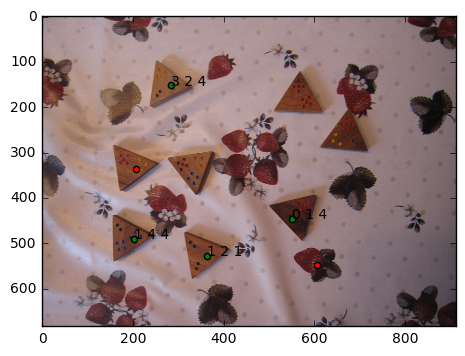

In [9]:
for triangle, r in zip(triangles, ranges):
    res = get_triangle_output(triangle, r)
    if type(res) != type(None):
        center, corners, points, corners_count = res
        plt.scatter(get_center(r)[1], get_center(r)[0], c = 'green')
        plt.text(get_center(r)[1], get_center(r)[0], ' '.join(map(lambda x : str(int(x)), corners_count)))
    else:
        plt.scatter(get_center(r)[1], get_center(r)[0], c = 'red')

plt.imshow(im)

# Отладочная информация для одного треугольника

## Треугольник

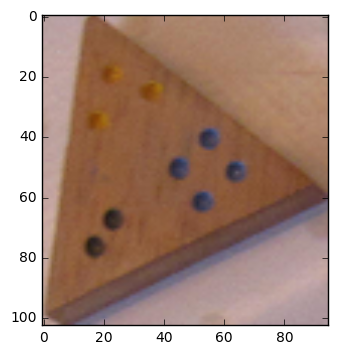

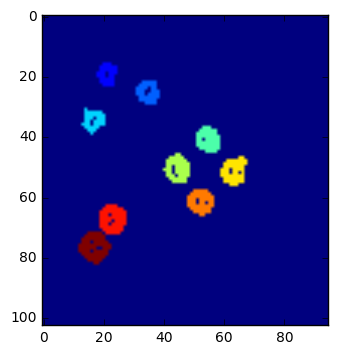

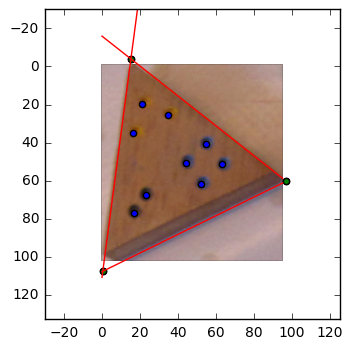

In [10]:
idx = 0
_ = get_triangle_output(triangles[idx], ranges[idx], 1)

## Не треугольник

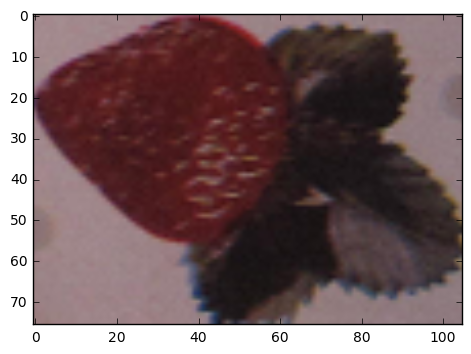

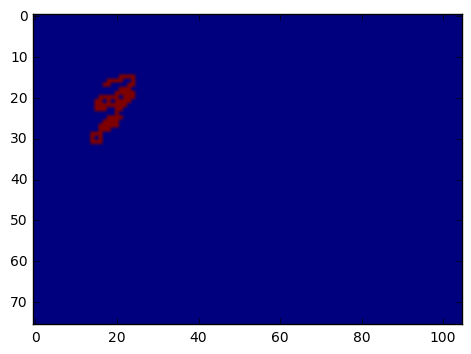

In [11]:
idx = 5
_ = get_triangle_output(triangles[idx], ranges[idx], 1)